## Auto HPO from scratch

In [304]:
# Loading the data
import pandas as pd
df = pd.read_csv(r"C:\Users\Abuba\Downloads\The_Cancer_data_1500_V2.csv")
Y = df['Diagnosis']
X = df.drop(columns=df.columns[-1])
X

,Age,Gender,BMI,Smoking,GeneticRisk,PhysicalActivity,AlcoholIntake,CancerHistory
0,58,1,16.085313,0,1,8.146251,4.148219,1
1,71,0,30.828784,0,1,9.361630,3.519683,0
2,48,1,38.785084,0,2,5.135179,4.728368,0
3,34,0,30.040296,0,0,9.502792,2.044636,0
4,62,1,35.479721,0,0,5.356890,3.309849,0
...,...,...,...,...,...,...,...,...
1495,62,1,25.090025,0,0,9.892167,1.284158,0
1496,31,0,33.447125,0,1,1.668297,2.280636,1
1497,63,1,32.613861,1,1,0.466848,0.150101,0
1498,55,0,25.568216,0,0,7.795317,1.986138,1


In [305]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 42)

In [306]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import random 
import warnings

In [307]:
#hyperparameter space
space = {
    'svm': {
        'model': svm.SVC(gamma = 'auto', probability = True),
        'params': {
            'C': [0.1, 0.5, 1, 5, 10],
            'kernel': ['rbf', 'linear', 'sigmoid'],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4, 5]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [4, 8, 12]
    }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear',multi_class='ovr'),
        'params': {
            'C' : [0.1, 0.5, 1, 5, 10],
            'penalty': ['l1', 'l2'],
            'max_iter': [100, 500, 1000]
        }
    }
}

In [308]:
def custom_cross_val_auc(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=cv_splits)
    auc_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train_cv, y_train_cv)
        y_prob = model.predict_proba(X_val_cv)[:, 1]  # Probability of positive class

        auc = roc_auc_score(y_val_cv, y_prob)
        auc_scores.append(auc)

    return np.array(auc_scores)
def objective_function(config, algo, X_train, Y_train):
    model = space[algo]['model']
    model.set_params(**config)
    auc_scores = custom_cross_val_auc(model, X_train, Y_train, cv_splits=5)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

In [312]:
observations = []

algorithms = list(space.keys())

for i in range(30):# initial HP config
    print(f"Trial: {i+1}/30")
    algo = random.choice(algorithms)
    if algo == 'svm':
        hyperparams = {
            'model': svm.SVC(gamma = 'auto', probability=True),
            'params': {
                'C': random.choice(space[algo]['params']['C']),
                'kernel': random.choice(space[algo]['params']['kernel']),
                'gamma': random.choice(space[algo]['params']['gamma']),
                'degree': np.random.choice(space[algo]['params']['degree'])
            }
        }
    elif algo == 'random_forest':
        hyperparams = {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': random.choice(space[algo]['params']['n_estimators']),
                'max_depth': (random.choice(space[algo]['params']['max_depth'])),
                'min_samples_split': random.choice(space[algo]['params']['min_samples_split']),
                'min_samples_leaf': random.choice(space[algo]['params']['min_samples_leaf'])
                }
            }
    elif algo == 'logistic_regression':
        hyperparams = {
        'model': LogisticRegression(solver = 'liblinear'),
        'params': {
            'C' : random.choice(space[algo]['params']['C']),
            'penalty': random.choice(space[algo]['params']['penalty']),
            'max_iter': random.choice(space[algo]['params']['max_iter'])
            }
        }
    #print(hyperparams)
    # Evaluate the objective function for these hyperparameters
    score = objective_function(hyperparams['params'], algo, X_train, Y_train)
    # Add the observation to the list
    observations.append((hyperparams, score))

Trial: 1/30
Trial: 2/30
Trial: 3/30
Trial: 4/30
Trial: 5/30
Trial: 6/30
Trial: 7/30
Trial: 8/30
Trial: 9/30
Trial: 10/30
Trial: 11/30
Trial: 12/30
Trial: 13/30
Trial: 14/30
Trial: 15/30
Trial: 16/30
Trial: 17/30
Trial: 18/30
Trial: 19/30
Trial: 20/30
Trial: 21/30
Trial: 22/30
Trial: 23/30
Trial: 24/30
Trial: 25/30
Trial: 26/30
Trial: 27/30
Trial: 28/30
Trial: 29/30
Trial: 30/30


In [21]:
observations

[({'model': LogisticRegression(solver='liblinear'),
   'params': {'C': 1, 'penalty': 'l1', 'max_iter': 100}},
  0.9082723323908029),
 ({'model': SVC(gamma='auto', probability=True),
   'params': {'C': 1, 'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 3}},
  0.5066928414088682),
 ({'model': SVC(gamma='auto', probability=True),
   'params': {'C': 5, 'kernel': 'linear', 'gamma': 'scale', 'degree': 3}},
  0.9085785711558267),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 30,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 10}},
  0.9425299325661121),
 ({'model': SVC(gamma='auto', probability=True),
   'params': {'C': 10, 'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 3}},
  0.5),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 20,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 10}},
  0.9357087845718614),
 ({'model': RandomForestClassifier(),
   'params': {'n_estimators': 30,
    'max_depth': 10

In [313]:
best_config = None
score = 0
curve = []
for i in range(50):
    model_name_to_space_key = {
    'svc': 'svm',
    'randomforestclassifier': 'random_forest',
    'logisticregression': 'logistic_regression'
    }

    # Encode the observations
    print(f"Trial: {i+1}/50")
    encoded_observations = []
    for obs in observations:
        hyperparams, score = obs
        model_class_name = hyperparams['model'].__class__.__name__.lower()
        algo_name = model_name_to_space_key[model_class_name]
        encoded_hyperparams = encode_hyperparameters(algo_name, hyperparams['params'])
        encoded_observations.append(encoded_hyperparams + [score])

    # Ensuring consistent length by padding with zeros
    max_length = max(len(obs) for obs in encoded_observations)
    padded_observations = np.array([obs + [0] * (max_length - len(obs)) for obs in encoded_observations])

    # Split into two groups X1 (best) and X2 (rest)
    sorted_observations = sorted(padded_observations, key=lambda x: x[-1], reverse=True)
    split_index = int(len(sorted_observations) * 0.3)
    if split_index == 0:
        split_index = 1

    X1 = np.array(sorted_observations[:split_index])
    X2 = np.array(sorted_observations[split_index:])
    if X1.ndim == 1:
        X1 = X1.reshape(1, -1)
    if X2.ndim == 1:
        X2 = X2.reshape(1, -1)
    if len(X1) == 0:
        X1 = np.array([sorted_observations[0]])
    if len(X2) == 0:
        X2 = np.array([sorted_observations[-1]])

    # Normalize X1 and X2
    scaler = StandardScaler()
    X1_normalized = scaler.fit_transform(X1)
    X2_normalized = scaler.transform(X2)

    # Fit Kernel Density Estimators
    def fit_kde(X):
        if len(X) < 2:
            return None
        kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X)
        return kde

    kde_x1 = fit_kde(X1_normalized)
    kde_x2 = fit_kde(X2_normalized)

    if kde_x1:
        sample_hyperparameters_normalized = kde_x1.sample()
        sample_hyperparameters = scaler.inverse_transform(sample_hyperparameters_normalized)
    else:
        sample_hyperparameters = X1  # Use X1 directly if KDE fitting is not possible

    if kde_x1 and kde_x2:
        log_prob_x1 = kde_x1.score_samples(sample_hyperparameters_normalized)
        log_prob_x2 = kde_x2.score_samples(sample_hyperparameters_normalized)
        log_ratio = log_prob_x1 - log_prob_x2
        ratio = np.exp(log_ratio)
    else:
        ratio = np.zeros(len(sample_hyperparameters))  # Fallback ratio

    best_hyperparameters = sample_hyperparameters[np.argmin(ratio)]

    def decode_hyperparameters(encoded_hyperparams, algo_name):
        decoded_hyperparams = {}
        index = 0
        for param_name in space[algo_name]['params']:
            if label_encoders[algo_name][param_name] is not None:  # Categorical parameter
                le = label_encoders[algo_name][param_name]
                decoded_value = le.inverse_transform([int(round(encoded_hyperparams[index]))])[0]
                decoded_hyperparams[param_name] = decoded_value
                index += 1
            else:
                decoded_hyperparams[param_name] = int(round(encoded_hyperparams[index]))
                index += 1
        return decoded_hyperparams

    def infer_algo_name(encoded_hyperparams):
        for algo_name, params_dict in label_encoders.items():
            expected_length = sum(len(le.classes_) if le is not None else 1 for le in params_dict.values())
            if len(encoded_hyperparams) == expected_length:
                return algo_name
        return None

    encoded_hyperparams_without_score = best_hyperparameters[:-1]
    inferred_algo_name = infer_algo_name(encoded_hyperparams_without_score)
    if inferred_algo_name is None:
        raise ValueError("Unable to infer the algorithm from the encoded hyperparameters.")
    # Append new observation
    if inferred_algo_name == 'svm':
        model_instance = svm.SVC(gamma = 'auto', probability=True)
    elif inferred_algo_name == 'random_forest':
        model_instance = RandomForestClassifier()
    elif inferred_algo_name == 'logistic_regression':
        model_instance = LogisticRegression(solver = 'liblinear')
    else:
        raise ValueError(f"Unknown algorithm '{inferred_algo_name}'")
    print(model_instance)
    
    decoded_hyperparams = decode_hyperparameters(encoded_hyperparams_without_score, inferred_algo_name)
    decoded_hyperparams = clip_hyperparameters(decoded_hyperparams, inferred_algo_name)
    
    observations.append(({"model": model_instance, "params": decoded_hyperparams}, best_hyperparameters[-1]))
    curve.append((i+1, best_hyperparameters[-1]))
    if(best_hyperparameters[-1]>score):
        best_model = model_instance
        best_config = decoded_hyperparams
        score = best_hyperparameters[-1]
    print(best_hyperparameters[-1])

Trial: 1/50
RandomForestClassifier()
0.9450733203931507
Trial: 2/50
RandomForestClassifier()
0.9112839402422275
Trial: 3/50
RandomForestClassifier()
0.9375826205848847
Trial: 4/50
RandomForestClassifier()
0.9314949562465681
Trial: 5/50
RandomForestClassifier()
0.9479554464849883
Trial: 6/50
RandomForestClassifier()
0.9496531853945138
Trial: 7/50
RandomForestClassifier()
0.9499366231717856
Trial: 8/50
RandomForestClassifier()
0.9376921413792988
Trial: 9/50
RandomForestClassifier()
0.9503231506652414
Trial: 10/50
RandomForestClassifier()
0.9356726420379853
Trial: 11/50
RandomForestClassifier()
0.9378011632921037
Trial: 12/50
RandomForestClassifier()
0.93466475479602
Trial: 13/50
RandomForestClassifier()
0.9452193875741558
Trial: 14/50
RandomForestClassifier()
0.9349422206821403
Trial: 15/50
RandomForestClassifier()
0.9450526047646218
Trial: 16/50
RandomForestClassifier()
0.932749913870525
Trial: 17/50
RandomForestClassifier()
0.9341837105513042
Trial: 18/50
RandomForestClassifier()
0.949

In [317]:

print(score)
best_config 

0.9498668679615795


{'n_estimators': 5,
 'max_depth': 5,
 'min_samples_split': 10,
 'min_samples_leaf': 5}

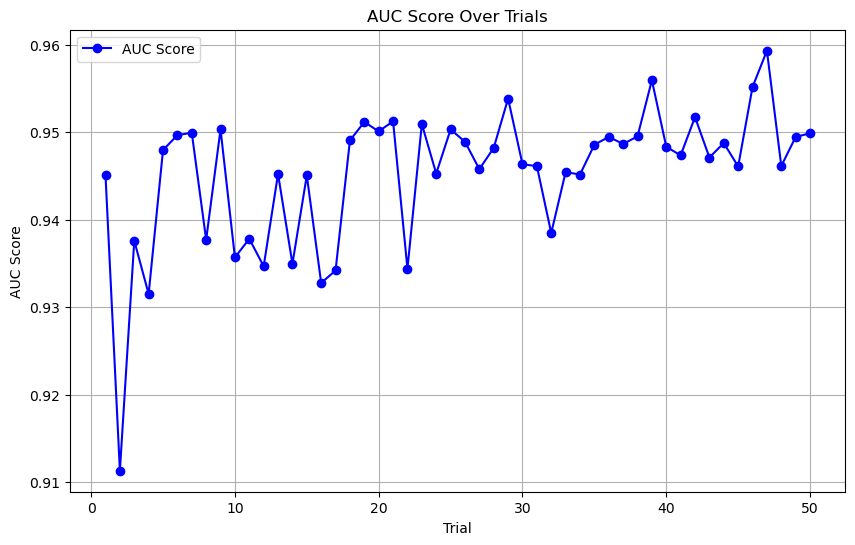

In [318]:
import matplotlib.pyplot as plt

# Separate the curve into two lists: x values and y values
x_values, y_values = zip(*curve)

# Plotting the curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='AUC Score')
plt.xlabel('Trial')
plt.ylabel('AUC Score')
plt.title('AUC Score Over Trials')
plt.legend()
plt.grid(True)
plt.show()


## Hyperparameter Optimization using Hyperopt

In [233]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

In [251]:
random_forest_space = {
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400, 500, 600]),
    'max_depth': hp.quniform('max_depth', 10, 1200, 10),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice("min_samples_leaf", [1, 5, 10])
}
svm_space = {
      'C': hp.choice('C', np.arange(0.1,10,0.5)),
      'kernel': hp.choice('kernel',['linear', 'sigmoid', 'rbf']),
      'degree':hp.choice('degree',[2,3,4]),
      }

logistic_regression_space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', np.log(1e-5), np.log(100)),
    'max_iter': hp.choice('max_iter',[100, 500, 1000])
}


In [256]:
def objective(random_forest_space):
    model = RandomForestClassifier(
        criterion=random_forest_space['criterion'],
        max_depth=int(random_forest_space['max_depth']),
        min_samples_leaf=int(random_forest_space['min_samples_leaf']),
        min_samples_split=int(random_forest_space['min_samples_split']),
        n_estimators=int(random_forest_space['n_estimators'])
    )
    
    roc_auc_score = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=4).mean()

    return {'loss': -roc_auc_score, "status": STATUS_OK}
def objective_svm(svm_space):
    model = svm.SVC(gamma = 'auto', probability=True,
                   C = svm_space['C'],
                   kernel = svm_space['kernel'],
                   degree = svm_space['degree'])
    roc_auc_score = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=4).mean()
    return {'loss': -roc_auc_score, "status": STATUS_OK}
def objective_lr(logistic_regression_space):
    model = LogisticRegression(solver = 'liblinear',multi_class='ovr',
                              penalty = logistic_regression_space['penalty'],
                              C = (logistic_regression_space['C']),
                              max_iter = logistic_regression_space['max_iter'])
    roc_auc_score = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=4).mean()
    return {'loss': -roc_auc_score, "status": STATUS_OK}

In [257]:
trials = Trials()
best = fmin(fn=objective,
            space=random_forest_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials)
print(best)
trials = Trials()
best = fmin(fn=objective_svm,
            space=svm_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials)
print(best)
trials = Trials()
best = fmin(fn=objective_lr,
            space=logistic_regression_space,
            algo=tpe.suggest,
            max_evals=15,
            trials=trials)
print(best)

100%|███████████████████████████████████████████████████████████| 15/15 [01:27<00:00,  5.85s/trial, best loss: -0.9452612306998273]
{'criterion': 0, 'max_depth': 880.0, 'min_samples_leaf': 0, 'min_samples_split': 1, 'n_estimators': 3}
100%|███████████████████████████████████████████████████████████| 15/15 [01:49<00:00,  7.27s/trial, best loss: -0.9084398855451488]
{'C': 17, 'degree': 0, 'kernel': 0}
100%|███████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 19.88trial/s, best loss: -0.9086791650388142]
{'C': 40.3597372814397, 'max_iter': 1, 'penalty': 0}


In [296]:
import numpy as np
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Define hyperparameter spaces with valid ranges and step sizes
space = {
    'random_forest': {
        'type': 'random_forest',
    'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'n_estimators': hp.quniform("n_estimators", 100, 600, 50), 
    'max_depth': hp.quniform('max_depth', 10, 1200, 10),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),  
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
    },
    'svm': {
        'type': 'svm',
        'C': hp.uniform('C', 0.1, 10),
        'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'rbf']),
        'degree': hp.choice('degree', [2, 3, 4])
    },
    'logistic_regression': {
        'type': 'logistic_regression',
        'penalty': hp.choice('penalty', ['l1', 'l2']),
        'C': hp.loguniform('C', np.log(1e-5), np.log(100)),
        'max_iter': hp.choice('max_iter', [100, 500, 1000])
    }
}

def objective(params):
    model_type = params.pop('type')
    
    if model_type == 'random_forest':
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        params['min_samples_leaf'] = int(params['min_samples_leaf'])
        params['n_estimators'] = int(params['n_estimators'])
        model = RandomForestClassifier(**params)
    elif model_type == 'svm':
        model = SVC(gamma='auto', probability=True, **params)
    elif model_type == 'logistic_regression':
        model = LogisticRegression(solver='liblinear', multi_class='ovr', **params)
    
    roc_auc = cross_val_score(model, X_train, Y_train, scoring='roc_auc', cv=4).mean()
    return {'loss': -roc_auc, 'status': STATUS_OK}

# Run optimization for each model type
for model_name, model_space in space.items():
    trials = Trials()
    best = fmin(fn=objective,
                space=model_space,
                algo=tpe.suggest,
                max_evals=15,
                trials=trials)
    print(f"Best parameters for {model_name}: {best}")


100%|███████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.19s/trial, best loss: -0.9462645739838722]
Best parameters for random_forest: {'criterion': 0, 'max_depth': 990.0, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 450.0}
100%|████████████████████████████████████████████████████████████| 15/15 [01:43<00:00,  6.92s/trial, best loss: -0.908404090465494]
Best parameters for svm: {'C': 8.30173585862787, 'degree': 1, 'kernel': 0}
100%|███████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 13.88trial/s, best loss: -0.9086672033163261]
Best parameters for logistic_regression: {'C': 33.532915663711144, 'max_iter': 2, 'penalty': 0}


In [ ]:
from sklearn.model_selection import learning_curve

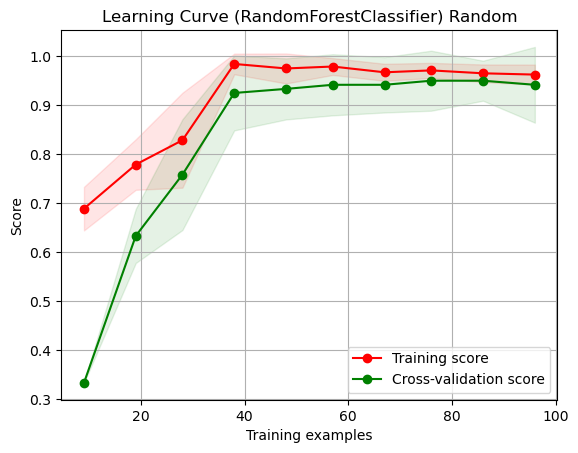

In [324]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.datasets import load_iris

# Load dataset (replace with your actual dataset)
data = load_iris()
X, y = data.data, data.target

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator
estimator_Optimized = RandomForestClassifier(
    n_estimators=5, 
    max_depth=5,  # Limit the depth of each tree
    min_samples_leaf=10,  # Minimum number of samples required to be at a leaf node
    min_samples_split = 5,
    random_state=42
)
estimator_HyperOpt = RandomForestClassifier(
    n_estimators=450, 
    max_depth=990,  # Limit the depth of each tree
    min_samples_leaf=2,  # Minimum number of samples required to be at a leaf node
    min_samples_split = 3,
    random_state=42
)
estimator_Random = RandomForestClassifier(
    n_estimators=150, 
    max_depth=10,  # Limit the depth of each tree
    min_samples_leaf=6,  # Minimum number of samples required to be at a leaf node
    min_samples_split = 8,
    random_state=42
)
# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    estimator_Random, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve (RandomForestClassifier) Random")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Plot the mean scores with standard deviation error bars
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()
